In [101]:
# Here we are looking at mushroom data and seeing if we can predict whether a mushroom is edible or poisonous.

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import seaborn as sb
from scipy import stats
mushrooms = pd.read_csv("mushrooms.csv")
display(mushrooms.head(10))
# The class column indicates whether the mushroom is poisonous (p) or edible (e).
# For more info on how the rest of this data is encoded, see https://www.kaggle.com/uciml/mushroom-classification#mushrooms.csv

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


In [103]:
# Let's explore whether cap color shows a useful relationship with edibility.
capColors = mushrooms.groupby(['cap-color', 'class'])
grouped = capColors[['class']].size().unstack().fillna(0)
grouped = grouped.reset_index()
print ("Number of edible samples = ", int(grouped.e.sum()))
print ("Number of poisonous samples = ", int(grouped.p.sum()))
propEdible = grouped.e / (grouped.e + grouped.p)
grouped['Edibility'] = propEdible
display(grouped)

Number of edible samples =  4208
Number of poisonous samples =  3916


class,cap-color,e,p,Edibility
0,b,48.0,120.0,0.285714
1,c,32.0,12.0,0.727273
2,e,624.0,876.0,0.416000
3,g,1032.0,808.0,0.560870
4,n,1264.0,1020.0,0.553415
5,p,56.0,88.0,0.388889
6,r,16.0,0.0,1.000000
7,u,16.0,0.0,1.000000
8,w,720.0,320.0,0.692308
9,y,400.0,672.0,0.373134


In [104]:
# Having a cap color of "r", "u", and "b" seems to provide some information, but overall this doesn't look promising. A mushroom can only have one cap color, so if we encode cap color as a set of variables (e.g. isRed, isBlue, etc.), there is no possibility of these variables combining in any interesting and surprising manner to help with our task, which is to predict edibility. However, down the road, we may decide to use cap color in combination with other variables.

In [105]:
# Let's look at odor.
odor = mushrooms.groupby(['odor', 'class'])
grouped = odor[['class']].size().unstack().fillna(0)
grouped = grouped.reset_index()
propEdible = grouped.e / (grouped.e + grouped.p)
grouped['propEdible'] = propEdible
display(grouped)

class,odor,e,p,propEdible
0,a,400.0,0.0,1.000000
1,c,0.0,192.0,0.000000
2,f,0.0,2160.0,0.000000
3,l,400.0,0.0,1.000000
4,m,0.0,36.0,0.000000
5,n,3408.0,120.0,0.965986
6,p,0.0,256.0,0.000000
7,s,0.0,576.0,0.000000
8,y,0.0,576.0,0.000000


In [106]:
# This looks extremely promising! Note how, with the exception of "n" (which means no odor), the other odors perfectly discriminate edibility. This is an unusual but pleasant surprise, and we can take advantage here and we should be able to use this feature alone to predict edibility with very good performance. Our predictive model could be a simple rule where we query the odor of a sample and return a yes or no depending on what the odor is. Let's see what happens if we use one hot encoding to transform the odor variable so that it can be readily used in a logistic regression classifier.

In [107]:
onehot = pd.get_dummies(mushrooms[['odor']])
onehot['edible'] = mushrooms['class']
onehot.replace({'edible':{'p':1}}, inplace=True)
onehot.replace({'edible':{'e':0}}, inplace=True)
features = onehot.drop(['edible'], axis=1, inplace = False)
outcome = onehot['edible']
# This is what the one hot encoded odor variables now look like.
display(features.head(5))

,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y
0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0


In [108]:
# Split the data into a training (70%) and test (30 %) set.
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, outcome, train_size=0.7)
model = linear_model.LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
# Let's look at the default scoring method output.
print(model.score(X_test, y_test))

0.98318293683347


In [109]:
# Looks like good performance. But let's calculate the F1 score to get a better idea of the model's performance.
predicted = model.predict(X_test)
actual = y_test
perf = pd.DataFrame({'predicted': predicted, 'actual': y_test})
perf = perf.reset_index(drop = True)
truePos = sum(perf.predicted * perf.actual)
falsePos = sum((perf.predicted == 1) & (perf.actual == 0))
trueNeg = sum((perf.predicted == 0) & (perf.actual == 0))
falseNeg = sum((perf.predicted == 0) & (perf.actual == 1))
precision = truePos / (truePos + falsePos)
recall = truePos / (truePos + falseNeg)
F1 = 2 * (precision * recall) / (precision + recall)
print(F1)

0.9815730337078651


In [110]:
# Looking good. However, we may be able to improve the performance on odorless mushrooms by using other features.

In [111]:
# First, let's filter the dataset so we are only looking at odorless mushrooms.
odorless = mushrooms[mushrooms['odor'] == 'n'].copy()
odorless = odorless.reset_index(drop = True)
display(odorless.head())
# Let's examine the association between the "class" variable (poisonous or edible), and each of the other variables (excluding odor, of course).
# We can use Cramer's V to do so. (Note: this is something I should have done at the beginning!)
def CramersV(confusionMatrix):
    """Calculates Cramer's V    
    Adapted from https://stackoverflow.com/a/39266194/6004891    
    """    
    chisquared = stats.chi2_contingency(confusionMatrix)[0]
    n = confusionMatrix.sum().sum()
    minDim = min(xtab.shape)
    
    if minDim < 2:
        return 0
    
    return np.sqrt(chisquared / (n * (minDim - 1)))
# Let's iterate through each of the features and store the measure of association between that feature and the class variable.
features = list(odorless.columns.get_values())
features.remove('class')
features.remove('odor')
strengths = [];

for i in features:
    xtab = pd.crosstab(odorless['class'], odorless[i])
    strengths.append(CramersV(xtab))     

associations = pd.DataFrame({'Feature': features, 'Strength': strengths})
display(associations)







,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
1,e,x,f,n,f,n,f,w,b,n,...,f,w,w,p,w,o,e,k,a,g
2,e,s,f,g,f,n,f,c,n,k,...,s,w,w,p,w,o,p,n,y,u
3,e,f,f,w,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,f,f,n,f,n,f,c,n,k,...,s,w,w,p,w,o,p,k,y,u


,Feature,Strength
0,cap-shape,0.345667
1,cap-surface,0.212258
2,cap-color,0.569685
3,bruises,0.032858
4,gill-attachment,0.041571
5,gill-spacing,0.072545
6,gill-size,0.244295
7,gill-color,0.508164
8,stalk-shape,0.290107
9,stalk-root,0.273034


In [112]:
# Looks like there are some features here that potentially encode information about edibility. Let's filter the features that have an association strength of >= 0.4
indToRemove = associations[ associations['Strength'] < 0.4 ].index 
associations.drop(indToRemove , inplace = True)
associations.reset_index(drop = True, inplace = True)
display(associations)

,Feature,Strength
0,cap-color,0.569685
1,gill-color,0.508164
2,stalk-surface-below-ring,0.480095
3,stalk-color-below-ring,0.476723
4,spore-print-color,0.785982
5,habitat,0.546884


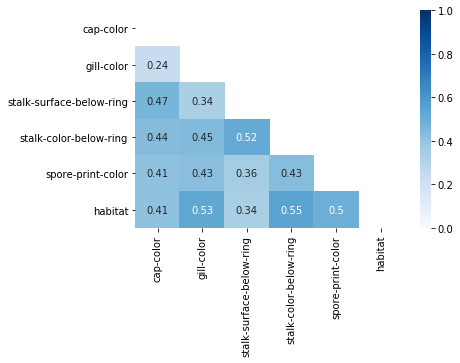

In [125]:
# Some of these features may be redundant to the task at hand. Let's build an association matrix and remove features that are highly associated with each other.
features = associations['Feature']
associationMatrix = pd.DataFrame(index = features, columns = features)

for i in features:
    for j in features:
        xtab = pd.crosstab(odorless[i], odorless[j])
        associationMatrix.loc[i, j] = CramersV(xtab)

associationMatrix.fillna(value=np.nan, inplace=True)
mask = np.zeros_like(associationMatrix, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
associationMatrix.index.name = None
associationMatrix.columns.name = None
heatmap = sb.heatmap(associationMatrix, cmap = "Blues", vmin = 0, vmax = 1, mask = mask, annot = True)


In [ ]:
# The highest association is only 0.55, so let's keep all these features.